In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
class MNISTWithBoundingBoxes:
    def __init__(self, train=True):
        self.dataset = datasets.MNIST(
            root='./data',
            train=train,
            download=True,
            transform=transforms.ToTensor()
        )

    def __getitem__(self, idx):
        img, label = self.dataset[idx]
        img_np = img.squeeze(0).numpy()  # Convert to numpy for bbox calculation

        # Calculate the bounding box for the digit
        rows, cols = np.where(img_np > 0)
        y_min, x_min = rows.min(), cols.min()
        y_max, x_max = rows.max(), cols.max()

        # Normalize the bounding box coordinates
        bbox = torch.tensor([x_min / 28, y_min / 28, x_max / 28, y_max / 28], dtype=torch.float32)

        return img, label, bbox

    def __len__(self):
        return len(self.dataset)
 # Initialize DataLoaders
train_dataset = MNISTWithBoundingBoxes(train=True)
test_dataset = MNISTWithBoundingBoxes(train=False)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:00<00:00, 14.6MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 485kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:00<00:00, 4.40MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 3.64MB/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [ ]:
class BoundingBoxModel(nn.Module):
    def __init__(self):
        super(BoundingBoxModel, self).__init__()
        self.backbone = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(32 * 7 * 7, 128),
            nn.ReLU(),  nn.Linear(128, 4)  # 4 outputs: [x_min, y_min, x_max, y_max]
        )

    def forward(self, x):
        features = self.backbone(x)
        bbox = self.fc(features)
        return bbox
 # Initialize the model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = BoundingBoxModel().to(device)


In [ ]:
criterion = nn.MSELoss()  # Loss for bounding box regression
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Optimizer

In [ ]:
epochs = 5
for epoch in range(epochs):
  model.train()
  total_loss = 0
  for imgs, _, bboxes in train_loader:
    imgs, bboxes = imgs.to(device), bboxes.to(device)

        # Forward pass
    pred_bboxes = model(imgs)

        # Compute loss
    loss = criterion(pred_bboxes, bboxes)

        # Backpropagation and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    total_loss += loss.item()

  print(f"Epoch [{epoch+1}/{epochs}], Loss: {total_loss / len(train_loader):.4f}")

Epoch [1/5], Loss: 0.0012
Epoch [2/5], Loss: 0.0003
Epoch [3/5], Loss: 0.0002
Epoch [4/5], Loss: 0.0002
Epoch [5/5], Loss: 0.0001


In [ ]:

 # Testing the Model
model.eval()
with torch.no_grad():
  for imgs, _, bboxes in test_loader:
    imgs, bboxes = imgs.to(device), bboxes.to(device)

    pred_bboxes = model(imgs)

        # Print the first sample's predicted and actual bounding box
    print("Predicted BBox:", pred_bboxes[0].cpu().numpy())
    print("Ground Truth BBox:", bboxes[0].cpu().numpy())
    break


Predicted BBox: [0.20839053 0.26290044 0.73856413 0.92649615]
Ground Truth BBox: [0.21428572 0.25       0.75       0.9285714 ]


In [ ]:
import matplotlib.pyplot as plt

def visualize_bbox(img, bbox, pred_bbox=None):
    """
    Visualize an image with its ground truth and predicted bounding boxes.

    Args:
        img (torch.Tensor): The input image (1x28x28) as a PyTorch tensor.
        bbox (torch.Tensor or numpy.ndarray): Ground truth bounding box [x_min, y_min, x_max, y_max] normalized to [0, 1].
        pred_bbox (torch.Tensor or numpy.ndarray, optional): Predicted bounding box [x_min, y_min, x_max, y_max] normalized to [0, 1].
    """
    # Convert image to numpy for visualization
    img = img.squeeze(0).numpy()

    # Denormalize the ground truth bounding box
    x_min, y_min, x_max, y_max = bbox * 28  # Convert normalized coordinates to pixel values
    plt.imshow(img, cmap='gray')
    plt.gca().add_patch(plt.Rectangle(
        (x_min, y_min),
        x_max - x_min,
        y_max - y_min,
        edgecolor='green',
        facecolor='none',
        lw=2,
        label="Ground Truth"
    ))

    # If a predicted bounding box is provided, denormalize and visualize it
    if pred_bbox is not None:
        px_min, py_min, px_max, py_max = pred_bbox * 28
        plt.gca().add_patch(plt.Rectangle(
            (px_min, py_min),
            px_max - px_min,
            py_max - py_min,
            edgecolor='red',
            facecolor='none',
            lw=2,
            label="Prediction"
        ))

    # Add legend and display the image
    plt.legend()
    plt.title("Bounding Box Visualization")
    plt.show()


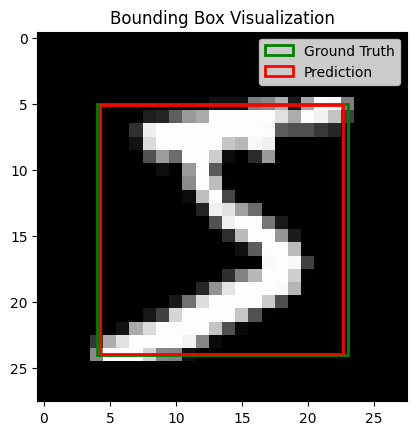

In [ ]:
# Assuming `model` is your trained model
img, _, bbox = train_dataset[0]  # Get the first sample from the training dataset

# Get model prediction (ensure the image is on the same device as the model)
img_tensor = img.unsqueeze(0).to(device)  # Add batch dimension and move to device
pred_bbox = model(img_tensor).cpu().detach().numpy()[0]  # Model prediction as numpy array

# Visualize the bounding boxes
visualize_bbox(img, bbox.numpy(), pred_bbox)
